In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    SqueezeDimd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
import ubelt as ub
import pint
site.addsitedir('../../../ARGUS')
from ARGUS_Transforms import ARGUS_RandSpatialCropSlicesd  # NOQA
Ureg = pint.UnitRegistry()

In [2]:
if False: #len(sys.argv) == 3:
    device_num = int(sys.argv[1])
    num_devices = int(sys.argv[2])
    print("Using device", str(device_num),"of", str(num_devices))
else:
    device_num = 0
    print("Device number assumed to be " + str(device_num))
    num_devices = 1

img1_dir = "../../Data_PNB/annotations_yuri/"
img2_dir = "../../Data_PNB_resized/annotations_yuri/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_cropM.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.overlay.mha')))

num_folds = 13

num_classes = 2

max_epochs = 1000

net_dims = 2 # Spatial Dimensions
net_in_channels = 4 # RawFrame, Mean, Std and MeanDiff
net_channels=(16, 32, 64, 128, 32)
net_strides=(2, 2, 2, 2)

num_workers_tr = 4
batch_size_tr = 8
num_workers_vl = 2
batch_size_vl = 2

num_slice = 32
size_x = 320
size_y = 640

model_filename_base = "./results/BAMC_PNB_ARUNet-3D-RawFrame_StdDevOverTime_MeanDiff-yuriArteryData-32s-VFold"

Device number assumed to be 0


In [3]:
# if not os.path.exists(model_filename_base):
#     os.makedirs(model_filename_base)

model_filename_base = model_filename_base+"/"

In [4]:
num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

p_prefix = ['3. 11 AC_Video 2',
            '3. 67 AC_Video 2', 
            '3. 93 AC_Video 2', 
            '3. 94 AC_Video 2', 
            '3. 134 AC_Video 2', 
            '3. 189 AC_Video 2', 
            '3. 205 AC_Video 2',
            '3. 217 AC_Video 2', 
            '3. 238 AC_Video 2', 
            '4. 211 AC_Video 3', 
            '4. 222A_Video 2',  
            '5. 153 AC_Video 3', 
            '5. 240 AC_Video 3',  
            '7. 193 AC Video 4']

n_prefix = ['1. 57 AC_Video 1',
            '1. 134 AC_Video 1',
            '1. 136 AC_Video 1', 
            '1. 179 AC_Video 1', 
            '1. 189 AC_Video 1', 
            '1. 204 AC Video 1', 
            '1. 205 AC_Video 1', 
            '1. 217 AC_Video 1', 
            '1. 238 AC_Video 1',  
            '2. 39 AC_Video 2',
            '5. 191 AC_Video 5']


fold_prefix_list = []
p_count = 0
n_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_p = 1
        num_n = 1
        if i > num_folds-2:
            num_p = 2
    else:
        num_p = 1
        num_n = 1
    f = []
    if p_count < len(p_prefix):
        for p in range(num_p):
            f.append([p_prefix[p_count+p]])
    p_count += num_p
    if n_count < len(n_prefix):
        for n in range(num_n):
            f.append([n_prefix[n_count+n]])
    n_count += num_n
    fold_prefix_list.append(f)

for i in range(num_folds):
    print(i, fold_prefix_list[i])

Num images / labels = 25 25
0 [['3. 11 AC_Video 2'], ['1. 57 AC_Video 1']]
1 [['3. 67 AC_Video 2'], ['1. 134 AC_Video 1']]
2 [['3. 93 AC_Video 2'], ['1. 136 AC_Video 1']]
3 [['3. 94 AC_Video 2'], ['1. 179 AC_Video 1']]
4 [['3. 134 AC_Video 2'], ['1. 189 AC_Video 1']]
5 [['3. 189 AC_Video 2'], ['1. 204 AC Video 1']]
6 [['3. 205 AC_Video 2'], ['1. 205 AC_Video 1']]
7 [['3. 217 AC_Video 2'], ['1. 217 AC_Video 1']]
8 [['3. 238 AC_Video 2'], ['1. 238 AC_Video 1']]
9 [['4. 211 AC_Video 3'], ['2. 39 AC_Video 2']]
10 [['4. 222A_Video 2'], ['5. 191 AC_Video 5']]
11 [['5. 153 AC_Video 3']]
12 [['5. 240 AC_Video 3'], ['7. 193 AC Video 4']]


In [5]:
total_bytes = 0
for p in all_images:
    #print(p)
    p = ub.Path(p)
    total_bytes += p.stat().st_size
print((total_bytes * Ureg.byte).to('GiB'))

total_bytes = 0
for p in all_labels:
    #print(p)
    p = ub.Path(p)
    total_bytes += p.stat().st_size
print((total_bytes * Ureg.byte).to('GiB'))

2.4898208379745483 gibibyte
0.012278499081730843 gibibyte


In [6]:
train_files = []
val_files = []
test_files = []

for i in range(num_folds):
    tr_folds = []
    va_folds = []
    for f in range(i,i+num_folds-4):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    for f in range(i+num_folds-4, i+num_folds-1):
        va_folds.append(fold_prefix_list[f%num_folds])
    va_folds = list(np.concatenate(va_folds).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

18 5 2
18 5 2
18 5 2
17 6 2
17 6 2
17 6 2
17 6 2
17 6 2
17 6 2
17 6 2
17 6 2
17 6 2
18 6 1


../../Data_PNB/annotations_yuri/1. 134 AC_Video 1_cropM.nii.gz
../../Data_PNB/annotations_yuri/1. 134 AC_Video 1_cropM.overlay.mha
(787, 901, 661)
(787, 901, 661)
Labels =  0 - 1


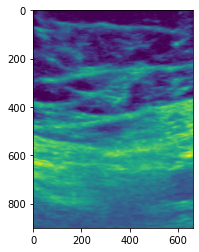

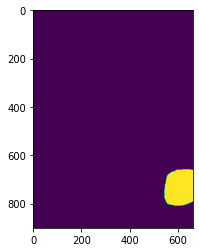

In [7]:
imgnum = 0

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
print(img.shape)
arrimg = itk.GetArrayFromImage(img)
print(arrimg.shape)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])
print("Labels = ", arrlbl[:,:,:].min(), "-", arrlbl[:,:,:].max())

In [8]:
#from ARGUS_Transforms import ARGUS_RandSpatialCropSlicesd
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slice,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=False,
            include_img=True,
            mean_pixel_diff=True,
            keys=['image','label']),
        Resized(
            spatial_size=(-1,640),
            mode=["bilinear","nearest"],
            keys=['image','label']
        ),
        RandSpatialCropd(
            roi_size=(size_x,size_y),
            random_center=True,
            random_size=False,
            keys=['image','label']
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slice,1],
            center_slice=num_slice/2,
            axis=0,
            reduce_to_statistics=[True,False],
            extended=False,
            include_img=True,
            mean_pixel_diff=True,
            keys=['image','label']),
        Resized(
            spatial_size=(-1,640),
            mode=["bilinear","nearest"],
            keys=['image','label']
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

In [9]:
device = torch.device("cuda:"+str(device_num))

In [10]:
def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=net_dims,
        in_channels=net_in_channels,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"],
                batch_data["label"]
            )
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                    f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"],
                        val_data["label"]
                    )
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)
                    roi_size = (size_x, size_y)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                       val_inputs, roi_size, sw_batch_size, model)
                    # val_outputs = model(val_inputs)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if epoch > 100:
                    metric = (metric_values[-1]+metric_values[-2]+metric_values[-3])/3
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), model_filename_base+'best_model.vfold_'+str(vfold_num)+'.pth')
                        print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
                torch.save(model.state_dict(), model_filename_base+'last_model.vfold_'+str(vfold_num)+'.pth')

    np.save(model_filename_base+"loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"val_dice_"+str(vfold_num)+".npy", metric_values)
    

In [11]:
for i in range(0,1,num_devices):
    #train_loader.dataset._cache.clear()
    # val_loader.dataset._cache.clear()
    #train_ds = CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
    #train_loader = DataLoader(train_ds, batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr)
    val_ds = CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
    val_loader = DataLoader(val_ds, batch_size=batch_size_vl, num_workers=num_workers_vl)
    #vfold_train(0, train_loader, val_loader)

Loading dataset: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


torch.Size([2, 4, 661, 640])
image shape: torch.Size([4, 661, 640]), label shape: torch.Size([1, 661, 640])


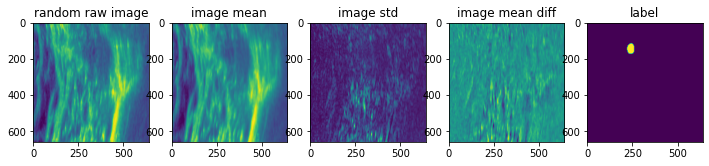

tensor(-0.0162) tensor(0.9757)
tensor(0.) tensor(1.)


In [14]:
imgnum = 0
check_data = first(val_loader)
image, label = (check_data["image"][imgnum], check_data["label"][imgnum])
print(check_data["image"].shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 8))
plt.subplot(1, 5, 1)
plt.title("random raw image")
plt.imshow(image[0, :, :])
plt.subplot(1, 5, 2)
plt.title("image mean")
plt.imshow(image[1, :, :])
plt.subplot(1, 5, 3)
plt.imshow(image[2, :, :])
plt.title("image std")
plt.subplot(1, 5, 4)
plt.imshow(image[3, :, :])
plt.title("image mean diff")
plt.subplot(1, 5, 5)
plt.title("label")
plt.imshow(label[0, :, :])
plt.show()
print(image.min(),image.max())
print(label.min(), label.max())